In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.metrics import mean_absolute_percentage_error
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
import joblib

#first load data
missing_vals = [' ?', 'n/a', '--', 'na', 'NaN', '', ' ']
dataset = pd.read_csv('./data/GridDemand.csv', encoding = 'utf-8-sig', header = 0, na_values = missing_vals)
dataset.head()

,COLLECTED_TIME,SYS_DEMAND,ARC_FURNACE,TEMPERATURE,WINDSPEED,WINDDIR,LIGHTINT,HUMIDITY,WINDGEN,UDH_ROLLEDUP_MW,UDH_WIND,INST_UPD_FLAG,SYS_DEMAND_EXP,UDH_ROLLEDUP_EXPORTED_MW,EWIC_EXP,SYS_DEMAND_ALL,WINDGEN_ALL,MOYLE_IC
0,01/01/2006 00:00,2824.3672,NaN,6.325,-0.945,10.295,32.361,79.75,381.3044,2823.0,381.0,NN,NaN,2727.0,NaN,NaN,NaN,NaN
1,01/01/2006 00:15,2816.2678,NaN,6.425,-0.945,283.290,19.698,79.80,372.8948,2817.0,373.0,NN,NaN,2721.0,NaN,NaN,NaN,NaN
2,01/01/2006 00:30,2758.3674,NaN,6.575,-0.945,312.045,16.884,79.85,392.5129,2760.0,393.0,NN,NaN,2666.0,NaN,NaN,NaN,NaN
3,01/01/2006 00:45,2702.5652,NaN,6.750,-0.945,133.835,28.140,79.80,418.1680,2699.0,418.0,NN,NaN,2607.0,NaN,NaN,NaN,NaN
4,01/01/2006 01:00,2637.9707,NaN,6.775,-0.945,314.885,16.884,79.40,447.0921,2636.0,447.0,NN,NaN,2546.0,NaN,NaN,NaN,NaN


In [2]:
#Data Quality Report

In [3]:
#ABT CONTINUOUS
continuous_feature_names = list(dataset.columns.values)
continuous_feature_names.remove('COLLECTED_TIME')
continuous_feature_names.remove('INST_UPD_FLAG')
continuous_feature_rows = []
continuous_headings = ['FEATURENAME', 'Count', '% Miss.', 'Card.', 'Min', '1st Qrt', 'Mean', 'Median', '3rd Qrt', 'Max', 'Std. Dev.']
#Continuous
for feature in continuous_feature_names:
    continuous_feature_rows.append([
        feature,
        dataset[feature].count(),
        round((dataset[feature].isnull().sum() / dataset[feature].count()) * 100, 2),
        len(dataset[feature].unique()),
        dataset[feature].min(),
        dataset[feature].quantile(0.25),
        dataset[feature].mean(),
        dataset[feature].quantile(0.5),
        dataset[feature].quantile(0.75),
        dataset[feature].max(),
        dataset[feature].std()        
    ])
    
continuous_features = pd.DataFrame(continuous_feature_rows, columns = continuous_headings)
continuous_features

C:\Users\Shane\AppData\Local\Temp/ipykernel_12232/994501809.py:12: RuntimeWarning: divide by zero encountered in longlong_scalars
  round((dataset[feature].isnull().sum() / dataset[feature].count()) * 100, 2),


,FEATURENAME,Count,% Miss.,Card.,Min,1st Qrt,Mean,Median,3rd Qrt,Max,Std. Dev.
0,SYS_DEMAND,490637,0.00,481111,0.0000,2088.905500,2644.902137,2669.96070,3230.99580,5236.3364,764.702404
1,ARC_FURNACE,1,49063600.00,2,0.0000,0.000000,0.000000,0.00000,0.00000,0.0000,NaN
2,TEMPERATURE,490617,0.00,2724,-45.0000,7.025000,10.473119,10.55950,14.06750,25.4159,4.698339
3,WINDSPEED,490628,0.00,1332,-27.8100,0.141000,1.532971,1.10780,2.19730,124.2000,4.601024
4,WINDDIR,490629,0.00,4096,-35.8550,103.362500,184.133639,212.00960,268.01970,356.5063,100.985453
5,LIGHTINT,489093,0.32,3331,-141.4035,0.488300,104.163377,20.40150,131.25400,1394.3370,175.402943
6,HUMIDITY,490629,0.00,2354,-0.2000,68.852800,74.096424,79.15000,81.15000,99.9969,14.006085
7,WINDGEN,490635,0.00,479005,-58.3210,148.056700,548.359634,366.40230,784.03735,3135.5769,534.669916
8,UDH_ROLLEDUP_MW,490439,0.04,4532,3.0000,2079.000000,2633.635298,2661.00000,3223.00000,5233.0000,768.162845
9,UDH_WIND,490439,0.04,2979,-26.0000,148.000000,548.442999,367.00000,784.00000,3136.0000,534.748922


In [4]:
#ABT CATEGORICAL
categorical_headings = ['FEATURENAME', 'Count', '% Miss.', 'Card.', 'Mode', 'Mode Freq.', 'Mode %', '2nd Mode', '2nd Mode Freq', '2nd Mode %']
categorical_feature_names = ['COLLECTED_TIME', 'INST_UPD_FLAG']
categorical_feature_rows = []

for feature in categorical_feature_names:
    categorical_feature_rows.append([
        feature,
        dataset[feature].count(),
        round((dataset[feature].isna().sum() / dataset[feature].count()) * 100, 2),
        len(dataset[feature].unique()),
        dataset[feature].value_counts().index.tolist()[0],
        dataset[feature].value_counts()[0],      
        round((dataset[feature].value_counts()[0] / dataset[feature].count()) * 100, 2),
        dataset[feature].value_counts().index.tolist()[1],
        dataset[feature].value_counts()[1],      
        round((dataset[feature].value_counts()[1] / dataset[feature].count()) * 100, 2),    
    ])

categorical_features = pd.DataFrame(categorical_feature_rows, columns = categorical_headings)
categorical_features

,FEATURENAME,Count,% Miss.,Card.,Mode,Mode Freq.,Mode %,2nd Mode,2nd Mode Freq,2nd Mode %
0,COLLECTED_TIME,490637,0.0,490637,01/01/2006 00:00,1,0.00,01/05/2015 16:30,1,0.0
1,INST_UPD_FLAG,490637,0.0,3,NI,483670,98.58,NN,6861,1.4


In [8]:
#EXPLORATORY ANALYSIS

In [9]:
#New dataframe for exploratory analysis
exploratory_df = dataset.copy()
exploratory_df['COLLECTED_TIME'] = pd.to_datetime(exploratory_df['COLLECTED_TIME'], dayfirst=True)
exploratory_df = exploratory_df.set_index("COLLECTED_TIME")
exploratory_df.index = pd.DatetimeIndex(exploratory_df.index)

exploratory_df['YEAR'] = exploratory_df.index.year
exploratory_df['MONTH'] = exploratory_df.index.month
exploratory_df['MONTH2'] = exploratory_df.index.month_name().str.slice(stop=3)

In [10]:
#HISTOGRAMS

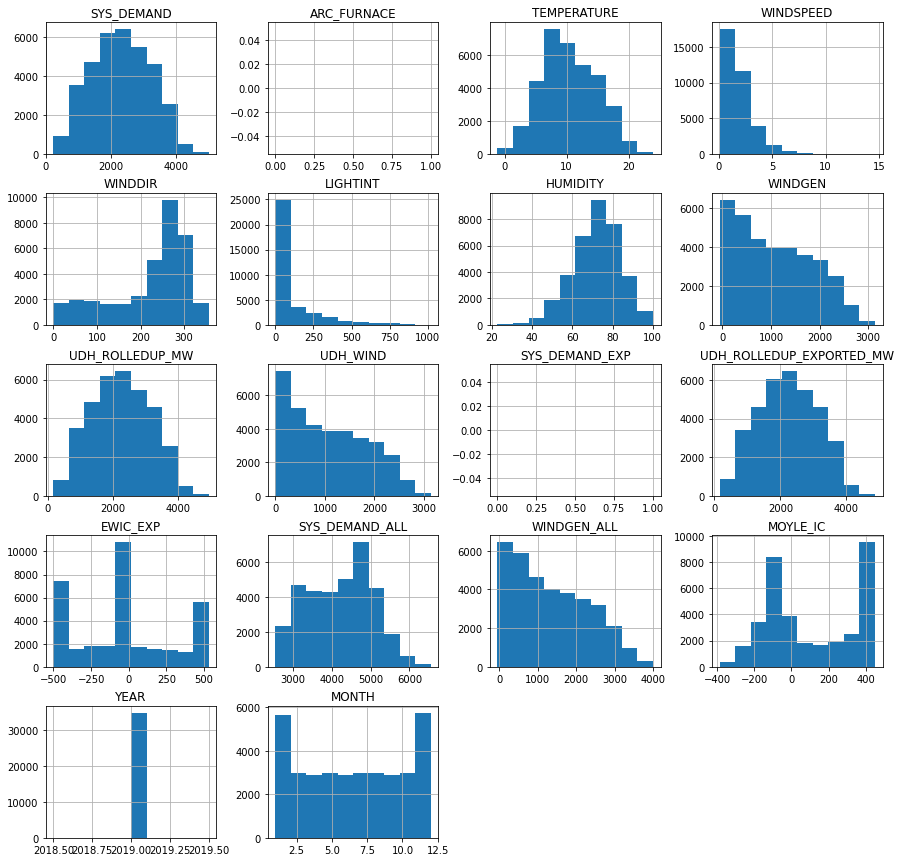

In [11]:
hist = exploratory_df[exploratory_df['YEAR'] == 2019].hist(bins=10, figsize=(15,15))

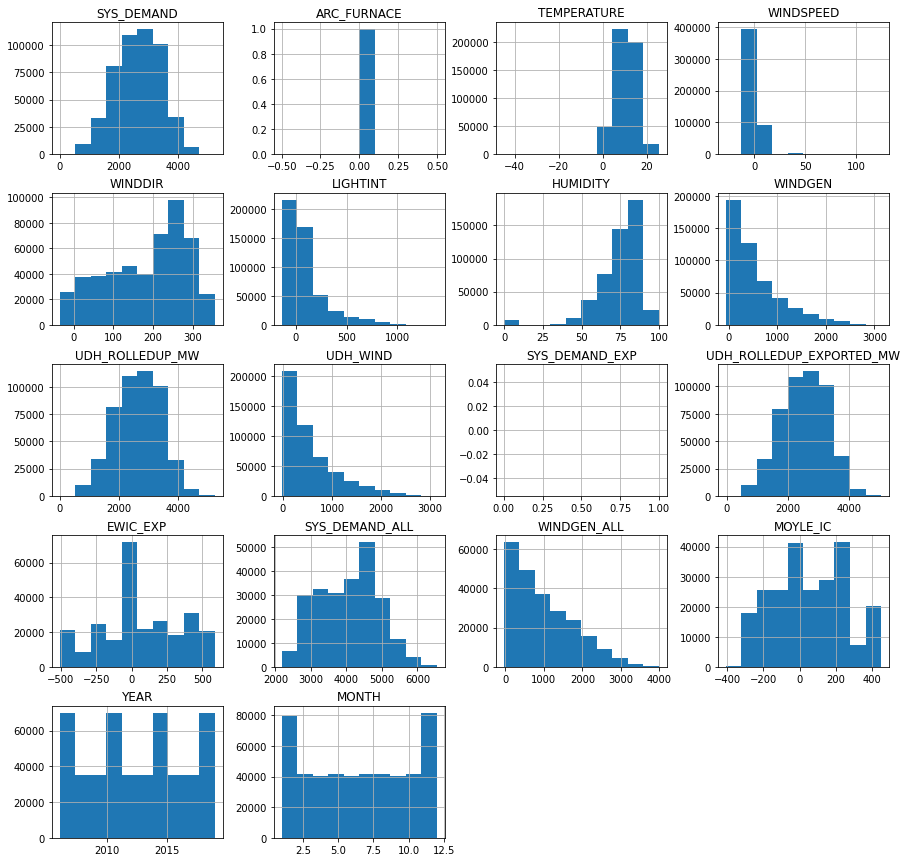

In [12]:
hist = exploratory_df.hist(bins=10, figsize=(15,15))

In [13]:
#BOXPLOTS

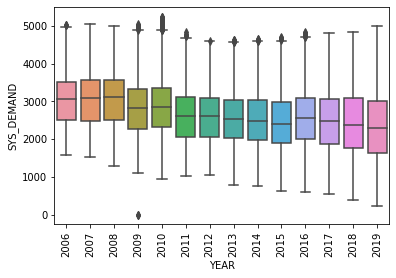

In [14]:
ax = sns.boxplot(data = exploratory_df, x='YEAR',y=('SYS_DEMAND'))
for item in ax.get_xticklabels():
    item.set_rotation(90)

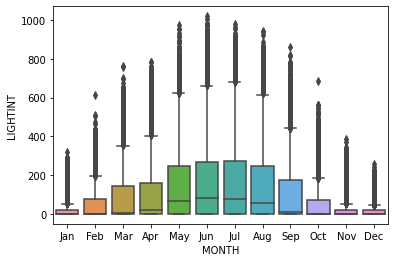

In [15]:
ax = sns.boxplot(data = exploratory_df[exploratory_df['YEAR'] == 2019], x='MONTH2',y=('LIGHTINT')).set(xlabel='MONTH')

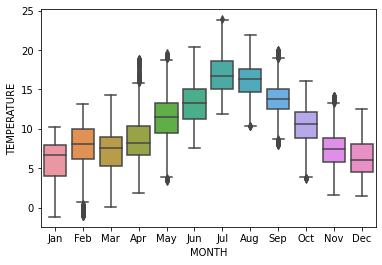

In [16]:
ax = sns.boxplot(data = exploratory_df[exploratory_df['YEAR'] == 2019], x='MONTH2',y=('TEMPERATURE')).set(xlabel='MONTH')

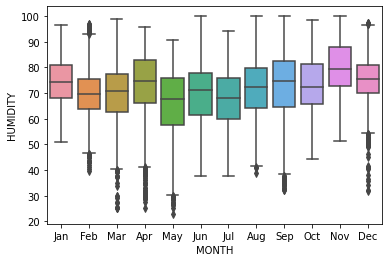

In [17]:
ax = sns.boxplot(data = exploratory_df[exploratory_df['YEAR'] == 2019], x='MONTH2',y=('HUMIDITY')).set(xlabel='MONTH')

array([[<AxesSubplot:xlabel='SYS_DEMAND', ylabel='SYS_DEMAND'>,
        <AxesSubplot:xlabel='TEMPERATURE', ylabel='SYS_DEMAND'>,
        <AxesSubplot:xlabel='WINDSPEED', ylabel='SYS_DEMAND'>,
        <AxesSubplot:xlabel='WINDDIR', ylabel='SYS_DEMAND'>,
        <AxesSubplot:xlabel='LIGHTINT', ylabel='SYS_DEMAND'>,
        <AxesSubplot:xlabel='HUMIDITY', ylabel='SYS_DEMAND'>,
        <AxesSubplot:xlabel='WINDGEN', ylabel='SYS_DEMAND'>],
       [<AxesSubplot:xlabel='SYS_DEMAND', ylabel='TEMPERATURE'>,
        <AxesSubplot:xlabel='TEMPERATURE', ylabel='TEMPERATURE'>,
        <AxesSubplot:xlabel='WINDSPEED', ylabel='TEMPERATURE'>,
        <AxesSubplot:xlabel='WINDDIR', ylabel='TEMPERATURE'>,
        <AxesSubplot:xlabel='LIGHTINT', ylabel='TEMPERATURE'>,
        <AxesSubplot:xlabel='HUMIDITY', ylabel='TEMPERATURE'>,
        <AxesSubplot:xlabel='WINDGEN', ylabel='TEMPERATURE'>],
       [<AxesSubplot:xlabel='SYS_DEMAND', ylabel='WINDSPEED'>,
        <AxesSubplot:xlabel='TEMPERATURE', ylabel='W

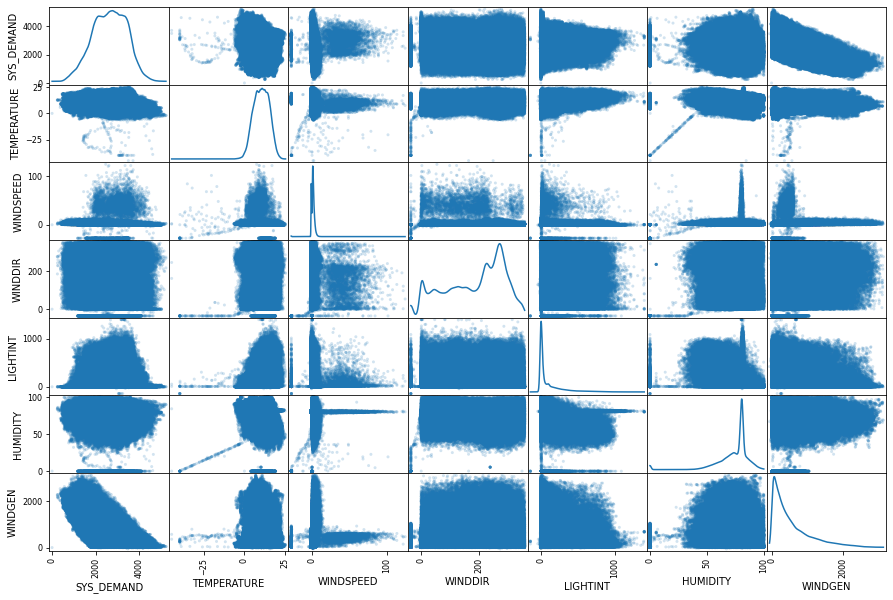

In [18]:
#SCATTER PLOTS
pd.plotting.scatter_matrix(dataset[['SYS_DEMAND', 'TEMPERATURE' ,'WINDSPEED' ,'WINDDIR' ,'LIGHTINT' ,'HUMIDITY', 'WINDGEN']], alpha=0.2, diagonal='kde', figsize=(15, 10))

In [19]:
#CORRELATION MATRIX
gd_correlation_matrix = dataset.corr()
gd_correlation_matrix

,SYS_DEMAND,ARC_FURNACE,TEMPERATURE,WINDSPEED,WINDDIR,LIGHTINT,HUMIDITY,WINDGEN,UDH_ROLLEDUP_MW,UDH_WIND,SYS_DEMAND_EXP,UDH_ROLLEDUP_EXPORTED_MW,EWIC_EXP,SYS_DEMAND_ALL,WINDGEN_ALL,MOYLE_IC
SYS_DEMAND,1.000000,NaN,-0.074595,-0.073743,-0.137439,0.225610,-0.057369,-0.564663,0.999076,-0.564753,NaN,0.999315,0.558893,0.623617,-0.620716,0.574006
ARC_FURNACE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TEMPERATURE,-0.074595,NaN,1.000000,-0.045386,-0.045685,0.338205,-0.143514,-0.086366,-0.071943,-0.086216,NaN,-0.070655,0.031787,-0.151576,-0.193151,-0.024840
WINDSPEED,-0.073743,NaN,-0.045386,1.000000,0.114507,0.004543,0.051275,0.163648,-0.074667,0.163587,NaN,-0.075658,-0.032125,0.113749,0.367191,-0.023486
WINDDIR,-0.137439,NaN,-0.045685,0.114507,1.000000,-0.058508,0.089174,0.172559,-0.142008,0.172571,NaN,-0.141503,-0.045597,-0.044740,0.065202,-0.010866
LIGHTINT,0.225610,NaN,0.338205,0.004543,-0.058508,1.000000,-0.295735,-0.078826,0.225878,-0.078738,NaN,0.228200,0.239272,0.223740,-0.088864,0.199558
HUMIDITY,-0.057369,NaN,-0.143514,0.051275,0.089174,-0.295735,1.000000,-0.072206,-0.055707,-0.072141,NaN,-0.059712,-0.169864,-0.257555,-0.033357,-0.156684
WINDGEN,-0.564663,NaN,-0.086366,0.163648,0.172559,-0.078826,-0.072206,1.000000,-0.574332,0.999998,NaN,-0.566195,-0.366771,0.208507,0.992132,-0.266345
UDH_ROLLEDUP_MW,0.999076,NaN,-0.071943,-0.074667,-0.142008,0.225878,-0.055707,-0.574332,1.000000,-0.574332,NaN,0.998322,0.567752,0.614609,-0.630269,0.568477
UDH_WIND,-0.564753,NaN,-0.086216,0.163587,0.172571,-0.078738,-0.072141,0.999998,-0.574332,1.000000,NaN,-0.566196,-0.366762,0.208515,0.992131,-0.266334


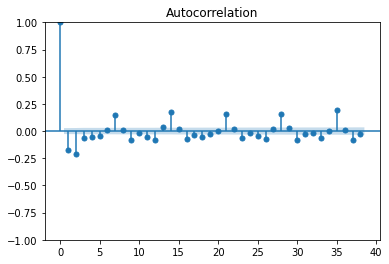

In [41]:
#TIME SPECIFIC ANALYSIS
#Plotting Autocorrelation
sm.graphics.tsa.plot_acf(aggregated.SYS_DEMAND.diff().dropna())
plt.show()

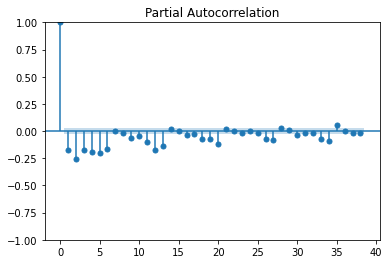

In [48]:
#PLOT PARTIAL AUTOCORRELATION
sm.graphics.tsa.plot_pacf(aggregated['SYS_DEMAND'].diff().dropna().values.squeeze())
plt.show()

In [45]:
#Explore the autocorrelation using ADFULLER 
X = aggregated["SYS_DEMAND"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.143900
p-value: 0.000011
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [24]:
#Preprocessing

In [25]:
#drop irrelevant columns
dataset = dataset[["COLLECTED_TIME", "SYS_DEMAND", "TEMPERATURE", "HUMIDITY", "LIGHTINT"]]
#also drop last row - only one 15 min interval, will skew data
dataset = dataset[:-1]

In [26]:
#Make timeseries - convert date column to datetime - Set date as index - filter to Belmullet
timeseries = dataset.copy()

#convert date to datetime and set as index
timeseries['DATE'] = pd.to_datetime(timeseries['COLLECTED_TIME'], dayfirst=True)
timeseries = timeseries.set_index("DATE")
timeseries.index = pd.DatetimeIndex(timeseries.index)

#create year month and named month columns
timeseries['YEAR'] = timeseries.index.year
timeseries['MONTH'] = timeseries.index.month
timeseries['MONTH2'] = timeseries.index.month_name().str.slice(stop=3)

timeseries.head()
#timeseries.index

,COLLECTED_TIME,SYS_DEMAND,TEMPERATURE,HUMIDITY,LIGHTINT,YEAR,MONTH,MONTH2
DATE,,,,,,,,
2006-01-01 00:00:00,01/01/2006 00:00,2824.3672,6.325,79.75,32.361,2006,1,Jan
2006-01-01 00:15:00,01/01/2006 00:15,2816.2678,6.425,79.80,19.698,2006,1,Jan
2006-01-01 00:30:00,01/01/2006 00:30,2758.3674,6.575,79.85,16.884,2006,1,Jan
2006-01-01 00:45:00,01/01/2006 00:45,2702.5652,6.750,79.80,28.140,2006,1,Jan
2006-01-01 01:00:00,01/01/2006 01:00,2637.9707,6.775,79.40,16.884,2006,1,Jan


In [27]:
#aggregate the timeseries - from 15min intervals to DAYS
timeseries.head()
aggregated = timeseries.groupby(pd.Grouper(freq="D"))
aggregated = aggregated.sum()

In [28]:
#'divide temp, lightint and humidity by 60/4*25'
for num, row in aggregated.iterrows():
    aggregated.loc[num, 'TEMPERATURE'] = row[1]/96
    aggregated.loc[num, 'HUMIDITY'] = row[2]/96
    aggregated.loc[num, 'LIGHTINT'] = row[3]/96
    aggregated.loc[num, 'YEAR'] = row[4]/96
    aggregated.loc[num, 'MONTH'] = row[5]/96

In [29]:
#shift over for lagged inputs
aggregated['LAG_1'] = aggregated['SYS_DEMAND'].shift(1)
aggregated['LAG_2'] = aggregated['LAG_1'].shift(1)
aggregated['LAG_3'] = aggregated['LAG_2'].shift(1)
aggregated = aggregated.drop(['2006-01-01', '2006-01-02', '2006-01-03'])
aggregated.head()

,SYS_DEMAND,TEMPERATURE,HUMIDITY,LIGHTINT,YEAR,MONTH,LAG_1,LAG_2,LAG_3
DATE,,,,,,,,,
2006-01-04,326071.2927,5.350521,79.779688,60.918703,2006.0,1.0,321440.2046,274297.4340,248069.4789
2006-01-05,320488.5316,4.970312,79.723438,35.013781,2006.0,1.0,326071.2927,321440.2046,274297.4340
2006-01-06,340471.5377,4.053646,79.609896,42.422516,2006.0,1.0,320488.5316,326071.2927,321440.2046
2006-01-07,309164.6961,4.113021,79.625000,32.844656,2006.0,1.0,340471.5377,320488.5316,326071.2927
2006-01-08,294312.6100,4.254427,79.663021,55.862297,2006.0,1.0,309164.6961,340471.5377,320488.5316


In [30]:
#then we will normalise the continuous features
continuous_feature_names = ["SYS_DEMAND", "TEMPERATURE", "HUMIDITY", "LIGHTINT", "LAG_1", "LAG_2", "LAG_3"]
aggregated_normalised = aggregated.copy()
for feature in continuous_feature_names:
    aggregated_normalised[[feature]] = normalize(aggregated_normalised[feature].values.reshape(-1, 1), axis=0)
aggregated_normalised.head()

,SYS_DEMAND,TEMPERATURE,HUMIDITY,LIGHTINT,YEAR,MONTH,LAG_1,LAG_2,LAG_3
DATE,,,,,,,,,
2006-01-04,0.017640,0.006584,0.014881,0.006613,2006.0,1.0,0.017388,0.014837,0.013417
2006-01-05,0.017338,0.006116,0.014870,0.003801,2006.0,1.0,0.017639,0.017386,0.014835
2006-01-06,0.018419,0.004988,0.014849,0.004605,2006.0,1.0,0.017337,0.017637,0.017385
2006-01-07,0.016725,0.005061,0.014852,0.003566,2006.0,1.0,0.018418,0.017335,0.017636
2006-01-08,0.015922,0.005235,0.014859,0.006064,2006.0,1.0,0.016724,0.018416,0.017334


In [31]:
#Machine Learning models
#Linear Regression (S)ARIMA(X)

In [32]:
#Linear Regression

In [33]:
# Training data
X = aggregated['LAG_1'].values #feature
Y = aggregated['SYS_DEMAND'].values #target
size = int(len(X) * 0.66)
x_train, x_test = X[0:size], X[size:len(X)]
y_train, y_test = Y[0:size], Y[size:len(X)]
x_train = x_train.reshape(-1, 1)

# Train the linear regression model
LINREG_model = LinearRegression().fit(x_train, y_train)

In [85]:
#SARIMAX train test split
X = aggregated['SYS_DEMAND'].values
eX = aggregated['HUMIDITY'].values.reshape(-1, 1)
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
trainEX, testEX = eX[0:size], eX[size:len(X)]

In [110]:
#SARIMAX

In [113]:
ARIMA_model = pm.auto_arima(train,
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=5, max_q=5, m=0,
                           start_P=0, seasonal=False,
                           d=None, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

ARIMA_model.summary()

SARIMA_model = pm.auto_arima(train,
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=30,
                           start_P=0, seasonal=True,
                           d=None, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

SARIMA_model.summary()

SARIMAX_model = pm.auto_arima(train, exogenous=trainEX,
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=30,
                           start_P=0, seasonal=True,
                           d=None, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

SARIMAX_model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=79280.190, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=93853.129, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=91434.950, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=79383.206, Time=0.31 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=78594.539, Time=0.44 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=90867.487, Time=0.14 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=78537.977, Time=0.98 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=2.52 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=78528.812, Time=0.46 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=78534.369, Time=0.23 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=78532.617, Time=1.05 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=78539.898, Time=1.17 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=78541.488, Time=0.83 sec
 ARIMA(3,0,4)(0,0,0)[0]        

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3371
Model:               SARIMAX(2, 0, 3)   Log Likelihood              -39258.406
Date:                Sat, 09 Apr 2022   AIC                          78528.812
Time:                        00:36:14   BIC                          78565.550
Sample:                             0   HQIC                         78541.948
                               - 3371                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1112      0.115      9.629      0.000       0.885       1.337
ar.L2         -0.1113      0.115     -0.964      0.335      -0.337       0.115
ma.L1         -0.4440      0.115     -3.849      0.000      -0.670      -0.218
ma.L2         -0.3688      0.048     -7.669      0.000      -0.463      -0.275
ma.L3         -0.0870      0.057     -1.526      0.127      -0.199       0.025
sigma2      7.657e+08   2.31e-10   3.32e+18      0.000    7.66e+08    7.66e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                38.55
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               2.23   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.99e+34. Standard errors may be unstable.
"""

In [38]:
#EVALUATION

In [40]:
#GET MAPE OF EACH MODEL (for SARIMAX)
X = aggregated['SYS_DEMAND'].values
eX = aggregated['HUMIDITY'].values.reshape(-1, 1)
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
testEX = eX[size:len(eX)]

predictions = ARIMA_model.predict(n_periods=len(test))

results = []
for i in range(len(predictions)):
    results.append([predictions[i], test[i]] )

mape = mean_absolute_percentage_error(test, predictions)
print(mape)

27.293477823
